In [ ]:
pip install tensorflow_text

In [ ]:
pip install -q tf-models-official

In [ ]:
pip install -U tfds-nightly

In [ ]:
import os, shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np
import logging
tf.get_logger().setLevel(logging.ERROR)

# Text Classification

## Data Import

In [ ]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url, untar=True, cache_dir='.', cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')
# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84131840/84125825 [==============================] - 4s 0us/step


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='training', seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2,subset='validation', seed=seed)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/test', batch_size=batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(2):
        print(f'\nReview: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'\nLabel : {label} ({class_names[label]})')


Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'

Label : 0 (neg)

Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as t

## Pre-processing

### Model Loading

In [ ]:
# Load model, visit https://www.tensorflow.org/tutorials/text/classify_text_with_bert
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

### Bert Pre-processing

3 outputs from the preprocessing that a BERT model would use (input_words_id, input_mask and input_type_ids).

The input_type_ids only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.
Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

In [ ]:
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


### Output

The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs:

- pooled_output to represent each input sequence as a whole. The shape is [batch_size, H]. 

- sequence_output represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the movie review.

- The first token of every input sequence is the special classification token – [CLS]. This token is used in classification tasks as an aggregate of the entire sequence representation. It is ignored in non-classification tasks.

- encoder_outputs are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L. In a 4-layers BERT model a token will have 4 intermediate representations. The last value of the list is equal to sequence_output.

For the fine-tuning you are going to use the pooled_output array.

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Encoder Outputs Shape:{bert_results["encoder_outputs"][-1].shape}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Sequence Outputs Shape:(1, 128, 512)
Encoder Outputs Shape:(1, 128, 512)


## Model
### Model Building

<img src="https://www.tensorflow.org/tutorials/text/classify_text_with_bert_files/output_0EmzyHZXKIpm_0.png" width="200" alt="Model Structure">

In [ ]:
def build_classifier_model():
    # define input, preprocessing and encoder layer
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    encoder_inputs = preprocessing_layer(text_input) # (m, 128)
    outputs = encoder(encoder_inputs) # 3 dictionaries    
    net = outputs['pooled_output'] #(m, 512)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net) # (m, 1)    
    return tf.keras.Model(text_input, net)

In [ ]:
# test
text_test = ['this is such  amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.56298554]], shape=(1, 1), dtype=float32)


### Model Training

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as AdamW.

For the learning rate (init_lr), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
# from_logits=True attribute inform the output values generated by the model are not normalized
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
tf.keras.backend.clear_session()
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = classifier_model.fit(x=train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/2
625/625 [==============================] - 166s 256ms/step - loss: 0.5561 - binary_accuracy: 0.6917 - val_loss: 0.3599 - val_binary_accuracy: 0.8376
Epoch 2/2
625/625 [==============================] - 157s 251ms/step - loss: 0.3378 - binary_accuracy: 0.8515 - val_loss: 0.3615 - val_binary_accuracy: 0.8416


## Evaluation

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 95s 121ms/step - loss: 0.3544 - binary_accuracy: 0.8493
Loss: 0.35442477464675903
Accuracy: 0.8493199944496155


In [ ]:
def print_my_examples(inputs, results):
    result_for_printing = \
    [f'input: {inputs[i]: <30} : score: {results[i][0]:.6f}' for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()

examples = [
    'this is such an amazing movie!',
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...']

In [ ]:
original_results = classifier_model(tf.constant(examples))
print_my_examples(examples, original_results)

input: this is such an amazing movie! : score: 0.996919
input: The movie was great!           : score: 0.982621
input: The movie was meh.             : score: 0.820238
input: The movie was okish.           : score: 0.130819
input: The movie was terrible...      : score: 0.012462



# Glue Task

## Solve GLUE tasks using BERT on TPU

BERT can be used to solve many problems in natural language processing. You will learn how to fine-tune BERT for many tasks from the [GLUE benchmark](https://gluebenchmark.com/):

1. [CoLA](https://nyu-mll.github.io/CoLA/) (Corpus of Linguistic Acceptability): Is the sentence grammatically correct?

1. [SST-2](https://nlp.stanford.edu/sentiment/index.html) (Stanford Sentiment Treebank): The task is to predict the sentiment of a given sentence.

1. [MRPC](https://www.microsoft.com/en-us/download/details.aspx?id=52398) (Microsoft Research Paraphrase Corpus): Determine whether a pair of sentences are semantically equivalent.

1. [QQP](https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs) (Quora Question Pairs2): Determine whether a pair of questions are semantically equivalent.

1. [MNLI](http://www.nyu.edu/projects/bowman/multinli/) (Multi-Genre Natural Language Inference): Given a premise sentence and a hypothesis sentence, the task is to predict whether the premise entails the hypothesis (entailment), contradicts the hypothesis (contradiction), or neither (neutral).

1. [QNLI](https://rajpurkar.github.io/SQuAD-explorer/)(Question-answering Natural Language Inference): The task is to determine whether the context sentence contains the answer to the question.

1. [RTE](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment)(Recognizing Textual Entailment): Determine if a sentence entails a given hypothesis or not.

1. [WNLI](https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html)(Winograd Natural Language Inference): The task is to predict if the sentence with the pronoun substituted is entailed by the original sentence.

This tutorial contains complete end-to-end code to train these models on a TPU. You can also run this notebook on a GPU, by changing one line (described below).

In this notebook, you will:

- Load a BERT model from TensorFlow Hub
- Choose one of GLUE tasks and download the dataset
- Preprocess the text
- Fine-tune BERT (examples are given for single-sentence and multi-sentence datasets)
- Save the trained model and use it

The following code connects to the TPU worker and changes TensorFlow's default device to the CPU device on the TPU worker. It also defines a TPU distribution strategy that you will use to distribute model training onto the 8 separate TPU cores available on this one TPU worker. See TensorFlow's [TPU guide](https://www.tensorflow.org/guide/tpu) for more information.

In [ ]:
# conenct to TPU worker
import os

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

Using TPU


## Pre-Processing

In [ ]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant(['Hello TensorFlow!']))
tok

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>

Each preprocessing model also provides a method, `.bert_pack_inputs(tensors, seq_length)`, which takes a list of tokens (like `tok` above) and a sequence length argument. This packs the inputs to create a dictionary of tensors in the format expected by the BERT model.

- input_mask The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the input_word_ids, and contains a 1 anywhere the input_word_ids is not padding.

- input_type_ids has the same shape as input_mask, but inside the non-padded region, contains a 0 or a 1 indicating which sentence the token is a part of.

In [ ]:
text_preprocessed = bert_preprocess.bert_pack_inputs([tok, tok], tf.constant(20))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids :  (1, 20)
Word Ids       :  tf.Tensor(
[  101  7592 23435 12314   999   102  7592 23435 12314   999   102     0
     0     0     0     0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 20)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 20)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)


In [ ]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  input_segments = [tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors) are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs, arguments=dict(seq_length=seq_length), name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

Two sentences input (input1 and input2). The output is what a BERT model would expect as input: input_word_ids, input_masks and input_type_ids.

In [ ]:
test_preprocess_model = make_bert_preprocess_model(['my_input1', 'my_input2'])
test_text = [np.array(['some random test sentence']), np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_mask', 'input_type_ids', 'input_word_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6251  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


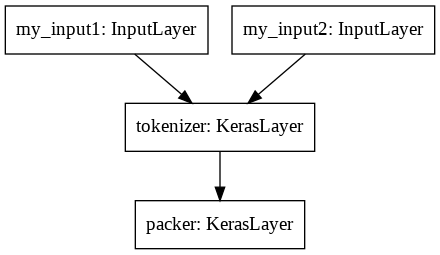

In [ ]:
tf.keras.utils.plot_model(test_preprocess_model)

## Model Building

In [ ]:
def build_classifier_model(num_classes):
  inputs = dict(
      input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
  )

  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='encoder')
  net = encoder(inputs)['pooled_output']
  net = tf.keras.layers.Dropout(rate=0.1)(net)
  net = tf.keras.layers.Dense(num_classes, activation=None, name='classifier')(net)
  return tf.keras.Model(inputs, net, name='prediction')

In [ ]:
test_classifier_model = build_classifier_model(2)
bert_raw_result = test_classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5823065  0.09207159]], shape=(1, 2), dtype=float32)


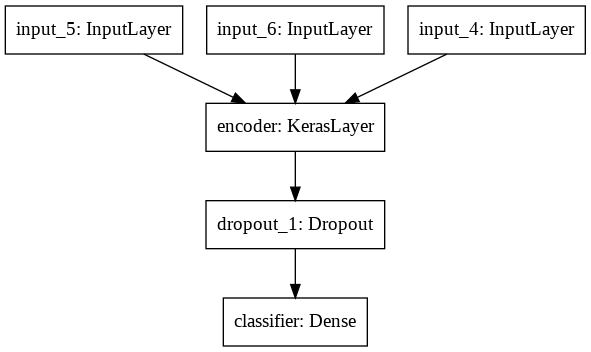

In [ ]:
tf.keras.utils.plot_model(test_classifier_model)

## Choose a task from GLUE

You are going to use a TensorFlow DataSet from the [GLUE](https://www.tensorflow.org/datasets/catalog/glue) benchmark suite.

Colab lets you download these small datasets to the local filesystem, and the code below reads them entirely into memory, because the separate TPU worker host cannot access the local filesystem of the colab runtime.

For bigger datasets, you'll need to create your own [Google Cloud Storage](https://cloud.google.com/storage) bucket and have the TPU worker read the data from there. You can learn more in the [TPU guide](https://www.tensorflow.org/guide/tpu#input_datasets).

It's recommended to start with the CoLa dataset (for single sentence) or MRPC (for multi sentence) since these are small and don't take long to fine tune.

In [ ]:
tfds_name = 'glue/cola' 

tfds_info = tfds.builder(tfds_name).info

sentence_features = list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

available_splits = list(tfds_info.splits.keys())
train_split = 'train'
validation_split = 'validation'
test_split = 'test'
if tfds_name == 'glue/mnli':
  validation_split = 'validation_matched'
  test_split = 'test_matched'

num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

with tf.device('/job:localhost'):
  # batch_size=-1 is a way to load the dataset into memory
  in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

# The code below is just to show some samples from the selected dataset
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])

labels_names = tfds_info.features['label'].names
print(labels_names)
print()

sample_i = 1
for sample_row in sample_dataset.take(5):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

Using glue/cola from TFDS
This dataset has 10657 examples
Number of classes: 2
Features ['sentence']
Splits ['test', 'train', 'validation']


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/cola/1.0.0. Subsequent calls will reuse this data.
Here are some sample rows from glue/cola dataset
['unacceptable', 'acceptable']

sample row 1
b'It is this hat that it is certain that he was wearing.'
label: 1 (acceptable)

sample row 2
b'Her efficient looking up of the answer pleased the boss.'
label: 1 (acceptable)

sample row 3
b'Both the workers will wear carnations.'
label: 1 (acceptable)

sample row 4
b'John enjoyed drawing trees for his syntax homework.'
label: 1 (acceptable)

sample row 5
b'We consider Leslie rather foolish, and Lou a complete idiot.'
label: 1 (acceptable)



## Loss Function

In [ ]:
def get_configuration(glue_task):
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  if glue_task == 'glue/cola':
    metrics = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
  else:
    metrics = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)

  return metrics, loss

## Data Import

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def load_dataset_from_tfds(in_memory_ds, info, split, batch_size, bert_preprocess_model):
  is_training = split.startswith('train')
  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  if is_training:
    dataset = dataset.shuffle(num_examples)
    dataset = dataset.repeat()
    
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples

## Optimizer

In [ ]:
tfds_name = 'glue/cola'

In [ ]:
epochs = 3
batch_size = 32
init_lr = 2e-5

print(f'Fine tuning {tfhub_handle_encoder} model')
bert_preprocess_model = make_bert_preprocess_model(sentence_features)

with strategy.scope():
  # metric have to be created inside the strategy scope
  metrics, loss = get_configuration(tfds_name)

  # train set
  train_dataset, train_data_size = load_dataset_from_tfds(in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model)
  steps_per_epoch = train_data_size // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = num_train_steps // 10

  # val set
  validation_dataset, validation_data_size = load_dataset_from_tfds(in_memory_ds, tfds_info, validation_split, batch_size,bert_preprocess_model)
  validation_steps = validation_data_size // batch_size

  # model classification
  classifier_model = build_classifier_model(num_classes)

  # optimzier
  optimizer = optimization.create_optimizer(init_lr=init_lr, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps, optimizer_type='adamw')

  # compiling
  classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  classifier_model.fit(x=train_dataset, validation_data=validation_dataset, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_steps=validation_steps)

Fine tuning https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3 model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("clip_by_global_norm/clip_by_global_norm/_0:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


267/267 [==============================] - 90s 101ms/step - loss: 0.5884 - MatthewsCorrelationCoefficient: 0.5911 - val_loss: 0.5063 - val_MatthewsCorrelationCoefficient: 0.5871
Epoch 2/3
267/267 [==============================] - 22s 81ms/step - loss: 0.3493 - MatthewsCorrelationCoefficient: 0.5958 - val_loss: 0.5379 - val_MatthewsCorrelationCoefficient: 0.5871
Epoch 3/3
267/267 [==============================] - 22s 81ms/step - loss: 0.2422 - MatthewsCorrelationCoefficient: 0.5942 - val_loss: 0.6141 - val_MatthewsCorrelationCoefficient: 0.5871


## Save Checkpoint

In [ ]:
main_save_path = './models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print('Saving', saved_model_path)

# Save everything on the Colab host (even the variables from TPU memory)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False, options=save_options)

Saving ./models/glue_cola_bert_en_uncased_L-12_H-768_A-12


## Evaluation

In [ ]:
with tf.device('/job:localhost'):
  reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def prepare(record):
  model_inputs = [[record[ft]] for ft in sentence_features]
  return model_inputs

def prepare_serving(record):
  model_inputs = {ft: record[ft] for ft in sentence_features}
  return model_inputs

def print_bert_results(test, bert_result, dataset_name):

  bert_result_class = tf.argmax(bert_result, axis=1)[0]

  if dataset_name == 'glue/cola':
    print('sentence:', test[0].numpy())
    if bert_result_class == 1:
      print('This sentence is acceptable')
    else:
      print('This sentence is unacceptable')

  elif dataset_name == 'glue/sst2':
    print('sentence:', test[0])
    if bert_result_class == 1:
      print('This sentence has POSITIVE sentiment')
    else:
      print('This sentence has NEGATIVE sentiment')

  elif dataset_name == 'glue/mrpc':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Are a paraphrase')
    else:
      print('Are NOT a paraphrase')

  elif dataset_name == 'glue/qqp':
    print('question1:', test[0])
    print('question2:', test[1])
    if bert_result_class == 1:
      print('Questions are similar')
    else:
      print('Questions are NOT similar')

  elif dataset_name == 'glue/mnli':
    print('premise   :', test[0])
    print('hypothesis:', test[1])
    if bert_result_class == 1:
      print('This premise is NEUTRAL to the hypothesis')
    elif bert_result_class == 2:
      print('This premise CONTRADICTS the hypothesis')
    else:
      print('This premise ENTAILS the hypothesis')

  elif dataset_name == 'glue/qnli':
    print('question:', test[0])
    print('sentence:', test[1])
    if bert_result_class == 1:
      print('The question is NOT answerable by the sentence')
    else:
      print('The question is answerable by the sentence')

  elif dataset_name == 'glue/rte':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Sentence1 DOES NOT entails sentence2')
    else:
      print('Sentence1 entails sentence2')

  elif dataset_name == 'glue/wnli':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Sentence1 DOES NOT entails sentence2')
    else:
      print('Sentence1 entails sentence2')

  print('BERT raw results:', bert_result[0])
  print()

In [ ]:
with tf.device('/job:localhost'):
  test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[test_split])
  for test_row in test_dataset.shuffle(1000).map(prepare).take(5):
    if len(sentence_features) == 1:
      result = reloaded_model(test_row[0])
    else:
      result = reloaded_model(list(test_row))
    print_bert_results(test_row, result, tfds_name)

sentence: [b'He is unhappy about his contact lenses.']
This sentence is acceptable
BERT raw results: tf.Tensor([-3.448251   2.0506988], shape=(2,), dtype=float32)

sentence: [b'Who whose parents attended the meeting is still enrolled in school?']
This sentence is acceptable
BERT raw results: tf.Tensor([-2.909539   1.3441969], shape=(2,), dtype=float32)

sentence: [b'Martha carves toys.']
This sentence is acceptable
BERT raw results: tf.Tensor([-3.149018   1.8215792], shape=(2,), dtype=float32)

sentence: [b'Nobody told Susan.']
This sentence is acceptable
BERT raw results: tf.Tensor([-3.7048357  1.970476 ], shape=(2,), dtype=float32)

sentence: [b'Somebody just left - guess who just left.']
This sentence is acceptable
BERT raw results: tf.Tensor([-3.5934112  1.9730823], shape=(2,), dtype=float32)



# Fine Tuning Bert Model

In [ ]:
pip install -q tf-models-official==2.4.0

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert
import json

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [ ]:
# This directory contains the configuration, vocabulary, and a pre-trained checkpoint
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

## Data Import

In [ ]:
glue, info = tfds.load(name='glue/mrpc', with_info=True, batch_size=-1)

In [ ]:
list(glue.keys())

['test', 'train', 'validation']

In [ ]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

In [ ]:
info.features['label'].names

['not_equivalent', 'equivalent']

In [ ]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


## Data Pre-Process

In [ ]:
tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(gs_folder_bert, "vocab.txt"), do_lower_case=True)
print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [ ]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([encode_sentence(s) for s in glue_train["sentence1"]])
sentence2 = tf.ragged.constant([encode_sentence(s) for s in glue_train["sentence2"]])

In [ ]:
print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())

Sentence1 shape: [3668, None]
Sentence2 shape: [3668, None]


In [ ]:
# preprend CLS
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

In [ ]:
# input mask
input_mask = tf.ones_like(input_word_ids).to_tensor()

In [ ]:
# type ids, for diff sentence
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

In [ ]:
# put everything together
def encode_sentence(s, tokenizer):
  '''Encode all sentences with SEP at the end'''
  tokens = list(tokenizer.tokenize(s))
  tokens.append('[SEP]')
  return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])

  sentence1 = tf.ragged.constant([encode_sentence(s, tokenizer) for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([encode_sentence(s, tokenizer) for s in np.array(glue_dict["sentence2"])])

  # prepend CLS
  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(gs_folder_bert, "vocab.txt"), do_lower_case=True)
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

In [ ]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels shape: (3668,)


## Model Building

In [ ]:
# load config file and pretrained model
bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
bert_config = bert.configs.BertConfig.from_dict(config_dict)

In [ ]:
config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=2)

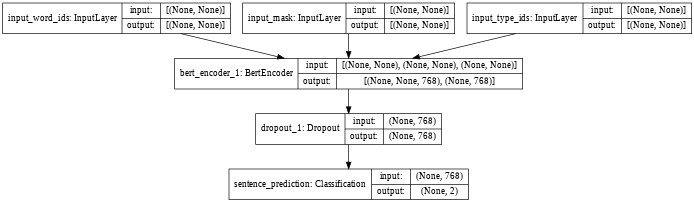

In [ ]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [ ]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}
bert_classifier(glue_batch, training=True).numpy()

array([[ 0.24647093,  0.11973207],
       [ 0.5389614 , -0.18634509],
       [ 0.3800509 , -0.07051852],
       [ 0.4632086 ,  0.02264099],
       [ 0.4484483 ,  0.0164614 ],
       [ 0.4794127 , -0.00083971],
       [ 0.44493636, -0.05322995],
       [ 0.38877878, -0.11506605],
       [ 0.51562035, -0.03297143],
       [ 0.6765623 ,  0.0233603 ]], dtype=float32)

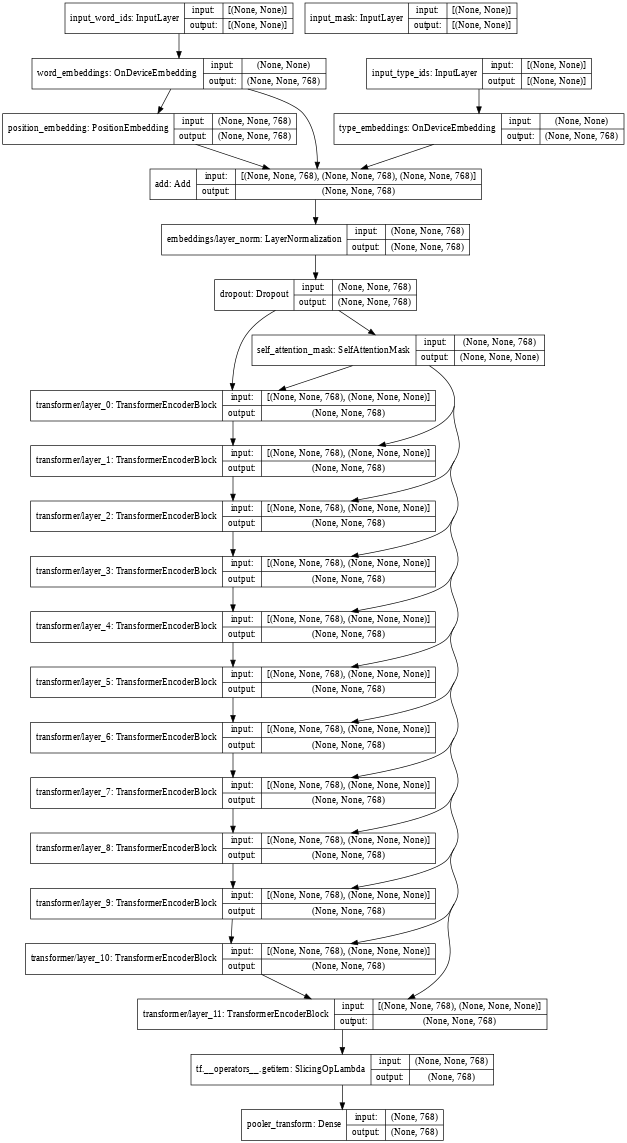

In [ ]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [ ]:
# When built the encoder is randomly initialized. Restore the encoder's weights from the checkpoint:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

## Optimizer

In [ ]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

## Model Training

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics)
bert_classifier.fit(glue_train, glue_train_labels, validation_data=(glue_validation, glue_validation_labels), batch_size=32, epochs=epochs)

Epoch 1/3
115/115 [==============================] - 156s 1s/step - loss: 0.6452 - accuracy: 0.6430 - val_loss: 0.5180 - val_accuracy: 0.7574
Epoch 2/3
115/115 [==============================] - 138s 1s/step - loss: 0.4841 - accuracy: 0.7831 - val_loss: 0.4349 - val_accuracy: 0.7966
Epoch 3/3
115/115 [==============================] - 139s 1s/step - loss: 0.3275 - accuracy: 0.8830 - val_loss: 0.4316 - val_accuracy: 0.8186


## Evaluation

In [ ]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':['The rain in Spain falls mainly on the plain.', 'Look I fine tuned BERT.'],
        'sentence2':['It mostly rains on the flat lands of Spain.', 'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

In [ ]:
result = bert_classifier(my_examples, training=False)
result = tf.argmax(result).numpy()
result

array([1, 0])

## Model Saving

In [ ]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [ ]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'], my_examples['input_mask'], my_examples['input_type_ids']], training=False)
original_result = bert_classifier(my_examples, training=False)
# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())

[[-1.0174804  0.7006732]
 [ 0.6347399 -0.6689524]]

[[-1.0174798   0.70067316]
 [ 0.63473845 -0.6689519 ]]
